In [1]:
import argparse
import sys
import json
from collections import namedtuple
from pathlib import Path
import logging
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
import pandas as pd
from tqdm import tqdm
import joblib as jl
import umap
import markov_clustering as mc
from quant.experiment import BaseExperiment, find_experiment_using_name, create_experiment
from quant.utils import print_options, read_parameter_values, print_parameters
from quant.viz import get_cluster_examples, make_cluster_grids
sys.path.append('..')
np.random.seed(72)  # ensure reproducibility for numpy and scikit-learn applications
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
commands = [
    '--task=tcga',
    '--experiment=mcl',
    '--data_dir=/mnt/rescomp/projects/TCGA_prostate/TCGA',
    '--segmentation_experiment=mpp0.4_active_learn_14f',
    '--rough_epochs=100',
    '--finetune_epochs=60',
    '--map_size=110',
    '--num_neighbors=3000',
    '--inflation=1.6'
]

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, help="Description of task")
parser.add_argument('--experiment', type=str, help="Experiment type - used to load desired experiment class")
parser.add_argument('--data_dir', type=Path, help="Directory where data is stored")
parser.add_argument('--preprocess_search', action='store_true', help="whether to instantiate a search over preprocessing parameters")
parser.add_argument('--exp_help', action='store_true')
args, unparsed = parser.parse_known_args(commands)

In [4]:
experiment_type = find_experiment_using_name(args.experiment, args.task)
parser = experiment_type.modify_commandline_options(parser)
args = parser.parse_args(commands)

/home/andrea/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
experiment: BaseExperiment = create_experiment(args)
Parameters = namedtuple('Parameters', ['rough_epochs', 'finetune_epochs', 'map_size', 'num_neighbors', 'inflation'])
read_par=lambda parameter: read_parameter_values(experiment.args, parameter)[0]
best_parameters = Parameters(
    rough_epochs=read_par('rough_epochs'),
    finetune_epochs=read_par('finetune_epochs'),
    map_size=read_par('map_size'),
    num_neighbors=read_par('num_neighbors'),
    inflation=read_par('inflation')
)
print_parameters(best_parameters)

----------------- Parameters ---------------
finetune_epochs: 60; inflation: 1.6; map_size: 110; num_neighbors: 3000; rough_epochs: 100; 
------------------------------------------------


In [6]:
evaluation_path = Path(f'/mnt/rescomp/projects/TCGA_prostate/TCGA/data/experiments/mcl/results/{experiment.format_parameters_key(best_parameters)}/evaluation_results.json')
with open(evaluation_path, 'r') as evaluation_results_file:
    best_result = json.load(evaluation_results_file)

In [7]:
best_som_path = experiment.save_dir / f'model_size:{best_parameters.map_size}_re:{best_parameters.rough_epochs}_fte{best_parameters.finetune_epochs}.joblib'
experiment.som = jl.load(best_som_path)

In [8]:
best_result['matrix'] = np.load(experiment.results_dir/experiment.format_parameters_key(best_parameters)/'simplicial_matrix.npy')
final_results_dir = experiment.save_dir/'final_result'
final_results_dir.mkdir(exist_ok=True, parents=True)
codebooks = experiment.som.codebook.matrix
# extract umap embedding to create vizualization for markov clustering
# print("Computing umap embedding ...")
# embedding_umap = umap.UMAP(n_neighbors=best_parameters.num_neighbors,
#                            min_dist=0.3,
#                            metric='euclidean', verbose=True).fit_transform(codebooks)
membership = np.vstack([[(x, idx) for x in cluster] for idx, cluster in enumerate(best_result['clusters'])])
membership = membership[membership[:, 0].argsort()]
membership_indices = membership[:, 1]

In [9]:
# This step takes very long for many codebooks
#print("Draw markov clustering graph")
#mc.draw_graph(best_result['matrix'], best_result['clusters'], pos=embedding_umap, node_size=50,
#              with_labels=False, edge_color="silver")

In [10]:
viz_path = Path(experiment.results_dir, f'mcl_{experiment.format_parameters_key(best_parameters)}.png')
plt.savefig(viz_path)

<Figure size 432x288 with 0 Axes>

In [11]:
experiment.read_data()

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Features were read (size: 95.43MB)
Data shape: (116459, 100)


/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


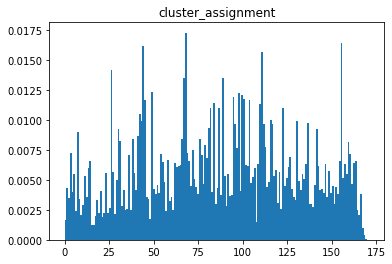

In [12]:
# assign each data-point to a code vector
nearest_neighbours = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(experiment.som.codebook.matrix)
distance, indices = nearest_neighbours.kneighbors(experiment.features)  # find nearest SOM cluster for each data-point
distance = distance.ravel()
indices = indices.ravel()
# assign each point to the markov cluster of his nearest codebook
cluster_assignment = pd.Series(data=[membership_indices[idx] for idx in indices], index=experiment.features.index)
plt.hist(cluster_assignment, bins=best_result['num_clusters'], density=True)
plt.title('cluster_assignment')
cluster_assignment.to_csv(final_results_dir/f'cluster_assignment_{experiment.format_parameters_key(best_parameters)}.csv')

In [13]:
print(max(max(c) for c in best_result['clusters']))
print(len(membership_indices))
print(len(indices))

12099
12100
116459


In [14]:
# gather examples from each cluster
som_cluster_membership = membership_indices
membership_numbers = [np.sum(cluster_assignment == p) for p in np.unique(som_cluster_membership)]
cluster_indices = list(p for p in np.unique(som_cluster_membership) if membership_numbers[p] > 10)  # exclude very small clusters
cluster_centers = tuple(experiment.som.codebook.matrix[np.where(som_cluster_membership == i)[0]]
                        for i in cluster_indices)
examples = get_cluster_examples(experiment.features, cluster_assignment,
                                image_dir=experiment.args.data_dir,
                                clusters=cluster_indices,
                                cluster_centers=cluster_centers,
                                n_examples=9)

clusters:   0%|          | 0/170 [00:00<?, ?it/s]/home/andrea/Documents/Repositories/cancer_phenotype/data/images/wsi_reader.py:85: UserWarning: No mpp or qc_mpp options - cannot perform quality control
  warnings.warn("No mpp or qc_mpp options - cannot perform quality control")
clusters: 100%|██████████| 170/170 [58:14<00:00, 20.56s/it] 


In [15]:
make_cluster_grids(examples, final_results_dir, experiment.name(), image_size=512)

  0%|          | 0/9 [00:00<?, ?it/s]

n clusters: 170


100%|██████████| 9/9 [07:49<00:00, 52.20s/it]


Done!


## Label Comparison

In [16]:
gleason_table_path = Path('/mnt/rescomp/projects/TCGA_prostate/TCGA/data/gdc_download_20190827_173135.969230/06efd272-a76f-4703-98b8-dfa751c0f019/nationwidechildrens.org_clinical_patient_prad.txt')
gleason_table = pd.read_csv(gleason_table_path, delimiter='\t', skiprows=lambda x: x in [1, 2])

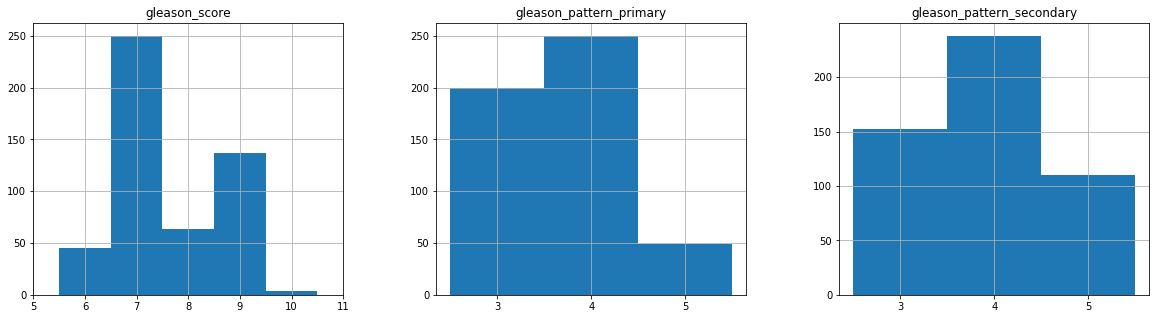

In [17]:
# Plot distribution of primary and secondary patterns
def replace_string_value(el):
    if isinstance(el, str):
        if el.isdigit():
            el = int(el)
        else:
            el = -1
    return el
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
gleason_pattern_primary = gleason_table.loc[:, 'gleason_score'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[5.5, 6.5, 7.5, 8.5, 9.5, 10.5], ax=axes[0])
gleason_pattern_primary = gleason_table.loc[:, 'gleason_pattern_primary'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[2.5, 3.5, 4.5, 5.5], ax=axes[1])
gleason_pattern_primary = gleason_table.loc[:, 'gleason_pattern_secondary'].to_frame().applymap(replace_string_value)
gleason_pattern_primary[gleason_pattern_primary != -1].hist(bins=[2.5, 3.5, 4.5, 5.5], ax=axes[2])
axes[0].set_xticks([5, 6, 7, 8, 9, 10, 11])
axes[1].set_xticks([3, 4, 5])
axes[2].set_xticks([3, 4, 5])
# primary pattern is most widespread pattern, second pattern is pattern with the highest score

In [18]:
gleason_table

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,histologic_diagnosis,histologic_diagnosis_other,zone_of_origin,gleason_pattern_primary,gleason_pattern_secondary,gleason_score,gleason_pattern_tertiary,...,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,patient_id,project_code,stage_other,system_version,tissue_source_site,tumor_tissue_site
0,49197847-CC83-4CE1-8397-D09CEA4C4928,TCGA-2A-A8VL,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,3,3,6,4,...,[Not Applicable],N0,T2b,[Not Applicable],A8VL,[Not Available],[Not Available],[Not Applicable],2A,Prostate
1,91C0D161-2B59-4B7A-8C19-6D26DEA31849,TCGA-2A-A8VO,2014-3-30,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,3,3,6,4,...,[Not Applicable],[Not Available],T3a,[Not Applicable],A8VO,[Not Available],[Not Available],[Not Applicable],2A,Prostate
2,931B549F-B9F2-4E8D-83ED-FF663671883C,TCGA-2A-A8VT,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,4,5,9,[Not Available],...,[Not Applicable],N1,T4,[Not Applicable],A8VT,[Not Available],[Not Available],[Not Applicable],2A,Prostate
3,75A7AFB5-66D5-47E3-8A8A-3E3A1E749A96,TCGA-2A-A8VV,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,3,3,6,4,...,[Not Applicable],N0,T2b,[Not Applicable],A8VV,[Not Available],[Not Available],[Not Applicable],2A,Prostate
4,942F1788-D977-4AC0-A177-659F9D4CD077,TCGA-2A-A8VX,2014-3-29,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,4,4,8,[Not Available],...,[Not Applicable],N0,T3b,[Not Applicable],A8VX,[Not Available],[Not Available],[Not Applicable],2A,Prostate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9B5D36B2-8B46-48A4-AFA7-0E1936F2D315,TCGA-ZG-A9M4,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,[Not Available],...,[Not Applicable],N1,T3b,[Not Applicable],A9M4,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
496,7EFC26B2-EFF9-4F1E-9F4B-F26AF072C84A,TCGA-ZG-A9MC,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Peripheral Zone,5,4,9,3,...,[Not Applicable],N1,T3b,[Not Applicable],A9MC,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
497,305B0B57-5952-43C7-9063-7BCD954EB44D,TCGA-ZG-A9N3,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,3,...,[Not Applicable],N1,T3b,[Not Applicable],A9N3,[Not Available],[Not Available],[Not Applicable],ZG,Prostate
498,348C2BF3-2146-4990-9ADF-FA6968B4F072,TCGA-ZG-A9ND,2014-7-18,Prostate Adenocarcinoma Acinar Type,[Not Applicable],Overlapping / Multiple Zones,5,4,9,3,...,[Not Applicable],N0,T3a,[Not Applicable],A9ND,[Not Available],[Not Available],[Not Applicable],ZG,Prostate


Calculate cluster histograms

In [19]:
# calculate cluster histograms
num_clusters=len(np.unique(cluster_assignment))
histograms = dict()
for slide_id in np.unique(cluster_assignment.index.get_level_values('slide_id')):
    assignments = cluster_assignment.loc[slide_id]
    histograms[slide_id] = np.histogram(assignments, bins=num_clusters, range=(0, num_clusters), density=True)[0]

In [20]:
histograms = pd.DataFrame(histograms).T  # slide ids will be index values instead of columns

In [21]:
# construct labels for the histogram datapoints
labels = []
for slide_id, row in histograms.iterrows():
    subtable = gleason_table[gleason_table['bcr_patient_barcode'].str.startswith(slide_id[:12])]
    assert(len(subtable) == 1)
    if subtable['gleason_pattern_primary'].iloc[0] == 3 and subtable['gleason_pattern_secondary'].iloc[0] == 4:
        labels.append('3+4')
    elif subtable['gleason_pattern_primary'].iloc[0] == 4 and subtable['gleason_pattern_secondary'].iloc[0] == 3:
        labels.append('4+3')
    elif subtable['gleason_score'].iloc[0] == 6:
        labels.append('low')
    else:
        labels.append('high')

In [22]:
print(len(histograms))
histograms

416


,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
TCGA-2A-A8VL-01Z-00-DX1.2C2BD6EF-EC17-4117-AE89-A22B67AFB233,0.000000,0.003226,0.000000,0.003226,0.000000,0.000000,0.000000,0.012903,0.003226,0.003226,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
TCGA-2A-A8VO-01Z-00-DX1.3A69CC37-B066-4529-B1BE-AD155983AAA7,0.000000,0.003012,0.000000,0.006024,0.003012,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012048,0.006024,0.003012,0.000000,0.006024,0.000000,0.000000,0.0,0.0,0.0
TCGA-2A-A8VT-01Z-00-DX1.F2CD9AAB-7B40-46A4-832B-1279A8A77737,0.006472,0.016181,0.012945,0.009709,0.022654,0.006472,0.003236,0.003236,0.016181,0.000000,...,0.003236,0.003236,0.000000,0.000000,0.000000,0.003236,0.000000,0.0,0.0,0.0
TCGA-2A-A8VV-01Z-00-DX1.DD094519-863E-42EF-8B36-F52418265E3E,0.000000,0.000000,0.013333,0.000000,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
TCGA-2A-A8VX-01Z-00-DX1.2A244F16-C24E-4CE9-8820-9E36B5441EC7,0.000000,0.000000,0.000000,0.000000,0.000000,0.004505,0.000000,0.027027,0.000000,0.000000,...,0.000000,0.013514,0.000000,0.000000,0.009009,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YL-A9WJ-01Z-00-DX1.ECE31D79-8A8E-45DB-8BC4-97B303D38B1B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.006944,0.000000,0.006944,0.000000,0.013889,0.003472,0.0,0.0,0.0
TCGA-YL-A9WK-01Z-00-DX1.8541045E-7FD4-4E74-BA15-9A0F57AF6BBA,0.000000,0.000000,0.000000,0.000000,0.000000,0.001176,0.001176,0.002353,0.000000,0.000000,...,0.002353,0.002353,0.004706,0.009412,0.002353,0.014118,0.002353,0.0,0.0,0.0
TCGA-YL-A9WL-01Z-00-DX1.4EE10C9A-18EA-4DB0-BE29-06F6A75FE5A0,0.000000,0.000000,0.000000,0.000000,0.002141,0.000000,0.006424,0.002141,0.002141,0.004283,...,0.000000,0.006424,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
TCGA-YL-A9WX-01Z-00-DX1.20B40B9A-C210-419D-B9A2-391DC92D9B7A,0.000000,0.000000,0.004184,0.004184,0.008368,0.000000,0.000000,0.004184,0.016736,0.000000,...,0.004184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [23]:
pca = PCA(n_components=2)
dim_reduced = pd.DataFrame(data=pca.fit_transform(histograms), index=histograms)

In [24]:
dim_reduced.shape

(416, 2)

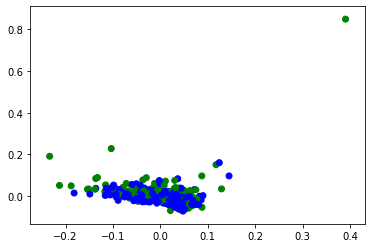

In [25]:
color_map = {'low': 'g', '3+4': 'g', '4+3': 'g', 'high': 'b'}
plt.scatter(dim_reduced.iloc[:, 0], dim_reduced.iloc[:, 1], c=[color_map[label] for label in labels])

In [26]:
dim_reduced = umap.umap_.UMAP(n_components=2).fit_transform(histograms)

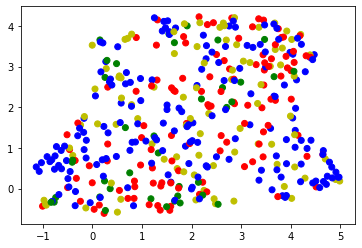

In [27]:
color_map = {'low': 'g', '3+4': 'r', '4+3': 'y', 'high': 'b'}
plt.scatter(dim_reduced[:, 0], dim_reduced[:, 1], c=[color_map[label] for label in labels])

(-0.1, 0.2)

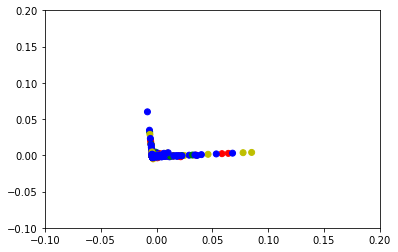

In [28]:
# extract most significant features
int_label_map = {'low': 0, '3+4': 1, '4+3': 2, 'high': 3}
chi2_values, pval = chi2(histograms, [int_label_map[label] for label in labels])
clusters_ordered_by_chi = [x for _, x in sorted(zip(chi2_values, list(range(histograms.shape[1]))), key=lambda pair: pair[0])]
chi_ordered_histograms = histograms.iloc[:, clusters_ordered_by_chi[:6]]
#dim_reduced = umap.umap_.UMAP(n_components=2).fit_transform(chi_ordered_histograms)
dim_reduced = PCA(n_components=2).fit_transform(chi_ordered_histograms)
color_map = {'low': 'g', '3+4': 'r', '4+3': 'y', 'high': 'b'}
plt.scatter(dim_reduced[:, 0], dim_reduced[:, 1], c=[color_map[label] for label in labels])
plt.xlim(-0.1, 0.2)
plt.ylim(-0.1, 0.2)

In [29]:
# train to predict gleason from clusters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
labels_rfc = [{'low': 0, '3+4': 1, '4+3': 2, 'high': 3}[label] for label in labels]
scores = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(histograms, labels_rfc, train_size=0.5)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, y_train)
    scores.append(rfc.score(X_test, y_test))
average_score = np.mean(scores)
print(average_score)

0.4553846153846154


<BarContainer object of 172 artists>

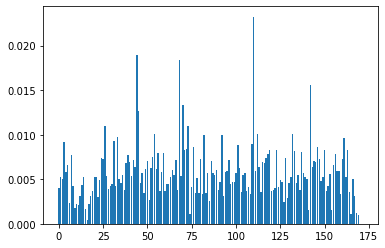

In [30]:
plt.bar(tuple(range(len(rfc.feature_importances_))), rfc.feature_importances_)

In [31]:
[x for _, x in sorted(zip(rfc.feature_importances_, list(range(len(rfc.feature_importances_)))), key=lambda pair: pair[0], reverse=True)]

[110,
 44,
 68,
 142,
 70,
 45,
 26,
 73,
 132,
 112,
 54,
 82,
 92,
 33,
 161,
 31,
 3,
 109,
 101,
 146,
 76,
 72,
 150,
 163,
 123,
 71,
 119,
 133,
 137,
 59,
 56,
 118,
 156,
 39,
 7,
 53,
 24,
 117,
 128,
 147,
 80,
 25,
 160,
 66,
 96,
 42,
 144,
 86,
 50,
 145,
 40,
 115,
 38,
 116,
 5,
 155,
 143,
 43,
 113,
 52,
 102,
 49,
 55,
 89,
 64,
 157,
 111,
 158,
 95,
 58,
 4,
 94,
 100,
 105,
 84,
 47,
 138,
 87,
 153,
 88,
 65,
 36,
 135,
 104,
 41,
 27,
 69,
 1,
 131,
 20,
 63,
 149,
 14,
 139,
 21,
 162,
 78,
 140,
 34,
 166,
 2,
 125,
 23,
 148,
 126,
 99,
 98,
 91,
 134,
 46,
 35,
 130,
 97,
 30,
 62,
 61,
 13,
 8,
 32,
 152,
 29,
 124,
 75,
 107,
 122,
 0,
 28,
 67,
 37,
 90,
 136,
 121,
 106,
 120,
 57,
 19,
 151,
 60,
 114,
 164,
 103,
 79,
 77,
 83,
 48,
 108,
 81,
 159,
 93,
 18,
 12,
 167,
 22,
 129,
 51,
 85,
 127,
 6,
 17,
 10,
 11,
 9,
 15,
 141,
 154,
 168,
 74,
 165,
 169,
 16,
 170,
 171]